In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
import os
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/utils')
sys.path.append('/Users/ben/Desktop/py_proj/account_funds_prediction/src')

from src.lightgbm_model import *
from utils.plots import *
from utils.metrics import *

In [2]:
sys.path

['/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/venv1/lib/python3.9/site-packages',
 '/Users/ben/Desktop/py_proj/account_funds_prediction',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/utils',
 '/Users/ben/Desktop/py_proj/account_funds_prediction/src']

## 1. Data creation v1 (random)

### 1.1. Key features

In [3]:
# number of rows and columns
num_clients = 200000

# Generate data for each column
np.random.seed(42)  # For reproducibility
data = {
    "funds_now": np.round(np.random.uniform(0, 10000000, num_clients), 1),  # funds balance at the current month

    # demographics
    "age": np.random.randint(18, 91, num_clients),  # Age range: 18-90
    "tenure": np.random.randint(0, 61, num_clients),  # Tenure range: 0-60 years
    "credit_score": np.random.randint(400, 801, num_clients),  # Credit score: 400-800
    "annual_income": np.random.randint(20000, 300001, num_clients),  # Income: $20k-$300k
    
    # other debt balance 
    "mtg_balance": np.round( np.random.uniform(0, 1000001, num_clients), 1),  # Mortgage balance
    "credit_card_balance": np.round( np.random.uniform(0, 50001, num_clients), 1),  # Credit card balance
    "loan_balance": np.round( np.random.uniform(0, 300001, num_clients), 1),  # Other loan balance
    "splc_balance": np.round( np.random.uniform(0, 800001, num_clients), 1), # Secured personal line of credit balance

    # behaviors
    "inflow": np.round( np.random.uniform(10, 200001, num_clients), 1),  # Monthly inflow (income or deposits)
    "outflow": np.round( np.random.uniform(10, 150001, num_clients), 1),  # Monthly outflow (expenses)

    "mobile_banking_ind": np.random.choice([0, 1], num_clients),  # Mobile banking indicator
    "premium_ind": np.random.choice([0, 1], num_clients),  # Premium user indicator
    "newcomer_ind": np.random.choice([0, 1], num_clients),  # Newcomer indicator (1 if a new customer)
    "days_since_last_log": np.random.randint(0, 366, num_clients),  # Days since last login (1-365 days)

}

df0 = pd.DataFrame(data)
df0.head()

,funds_now,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,splc_balance,inflow,outflow,mobile_banking_ind,premium_ind,newcomer_ind,days_since_last_log
0,3745401.2,89,0,495,166808,447983.5,13363.2,125336.5,571349.9,143109.3,76753.4,1,0,0,141
1,9507143.1,58,56,545,255821,330870.1,6747.4,132791.0,672813.3,90383.2,97241.0,1,0,1,34
2,7319939.4,71,55,763,269105,160977.9,43116.7,256166.3,658514.5,138673.1,9335.6,1,0,0,204
3,5986584.8,27,23,662,95336,820605.8,45966.0,9042.9,251251.2,116393.6,148450.5,1,0,1,104
4,1560186.4,35,3,745,267617,13641.9,32255.2,137387.3,628007.3,135588.9,140814.4,0,0,1,265


### 1.2 Create 35 random variables

In [4]:
num_features = 35

# Generate feature 16 to 30 (positive float)
for i in range(16, 31):
    data[f"fea{i}"] = np.round( np.random.rand(num_clients) * 200000, 1)  # Scale to desired range

# Generate feature 31 to 46 (positive or negative float)
for i in range(31, 46):
    data[f"fea{i}"] = np.round( (np.random.rand(num_clients) - 0.5) * 100000, 1)  # Centered around 0, scale to desired range

# Generate last 5 features (binary: 0 or 1)
for i in range(46, 51):
    data[f"fea{i}"] = np.round( np.random.randint(0, 2, num_clients) , 1 )



In [5]:
df1 = pd.DataFrame(data)
df1.head()

,funds_now,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,splc_balance,inflow,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
0,3745401.2,89,0,495,166808,447983.5,13363.2,125336.5,571349.9,143109.3,...,6946.4,46416.8,-46465.9,10142.4,-24174.7,1,1,0,1,0
1,9507143.1,58,56,545,255821,330870.1,6747.4,132791.0,672813.3,90383.2,...,-5437.0,46827.0,1489.1,23589.7,44598.0,1,1,0,0,0
2,7319939.4,71,55,763,269105,160977.9,43116.7,256166.3,658514.5,138673.1,...,15458.5,45763.1,7243.7,-37929.0,-5582.4,1,1,1,1,1
3,5986584.8,27,23,662,95336,820605.8,45966.0,9042.9,251251.2,116393.6,...,-16568.7,8365.8,19994.2,3653.6,-34610.4,1,1,0,1,1
4,1560186.4,35,3,745,267617,13641.9,32255.2,137387.3,628007.3,135588.9,...,-28389.5,-36297.4,40752.8,-23584.9,11822.9,0,1,1,0,1


### 1.3 Create target variables (future funds after 6 months)

In [6]:
# Add some logic for realistic simulation
df1["funds_after_6months"] = (
      0.5 * data["funds_now"] 
    + 0.05 * data["age"]
    + 0.08 * data["tenure"]
    + 0.03 * data["credit_score"]  # Credit score could impact balance growth
    + 0.2 * data["annual_income"]  # Higher income may correlate with higher balances
    
    + 0.1 * data["inflow"]  # Balance may increase with higher inflows
    - 0.06 * data["outflow"]  # Decrease with higher outflows
    
    - 0.2 * data["mtg_balance"]  # Higher mortgage balance may decrease balance growth
    - 0.1 * data["credit_card_balance"]  # Higher credit card balance might reduce growth
    - 0.05 * data["splc_balance"]  # secured plc might derease future balance
    - 0.15 * data["loan_balance"]
    
    - 0.1 * data["days_since_last_log"]  # Longer inactivity might slightly decrease balance
    + 0.2 * data["mobile_banking_ind"]
    + 0.3 * data["premium_ind"]
    - 0.2 * data["newcomer_ind"]
    
    + np.random.normal(0, 100000, num_clients)  # Adding some noise
)

# Clip the balance after 6 months to a reasonable range (0 to 11 million)
df1["funds_after_6months"] = np.round(np.clip(df1["funds_after_6months"], 0, 11000000), 1)

# Display a preview of the data
df1.head()

,funds_now,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,splc_balance,inflow,...,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50,funds_after_6months
0,3745401.2,89,0,495,166808,447983.5,13363.2,125336.5,571349.9,143109.3,...,46416.8,-46465.9,10142.4,-24174.7,1,1,0,1,0,1719526.1
1,9507143.1,58,56,545,255821,330870.1,6747.4,132791.0,672813.3,90383.2,...,46827.0,1489.1,23589.7,44598.0,1,1,0,0,0,4735021.3
2,7319939.4,71,55,763,269105,160977.9,43116.7,256166.3,658514.5,138673.1,...,45763.1,7243.7,-37929.0,-5582.4,1,1,1,1,1,3553297.1
3,5986584.8,27,23,662,95336,820605.8,45966.0,9042.9,251251.2,116393.6,...,8365.8,19994.2,3653.6,-34610.4,1,1,0,1,1,2999878.3
4,1560186.4,35,3,745,267617,13641.9,32255.2,137387.3,628007.3,135588.9,...,-36297.4,40752.8,-23584.9,11822.9,0,1,1,0,1,915613.1


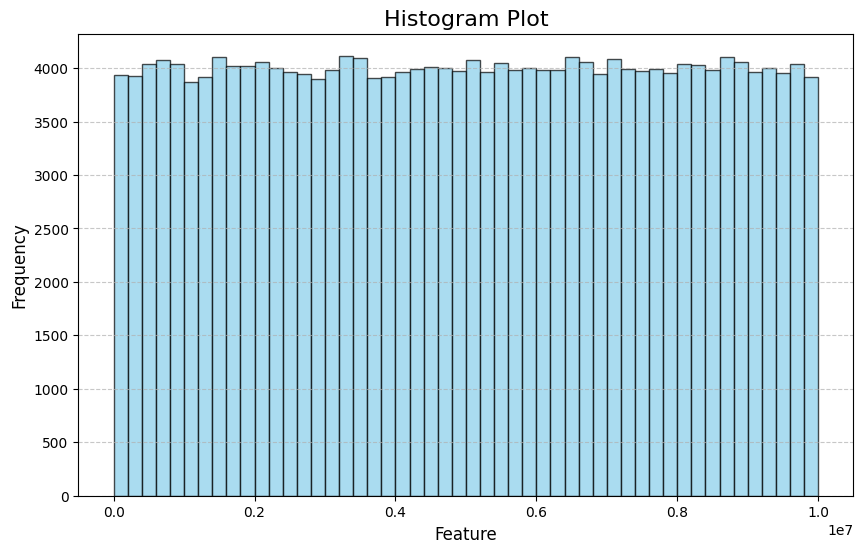

In [7]:
histogram_plot(df1, 'funds_now')

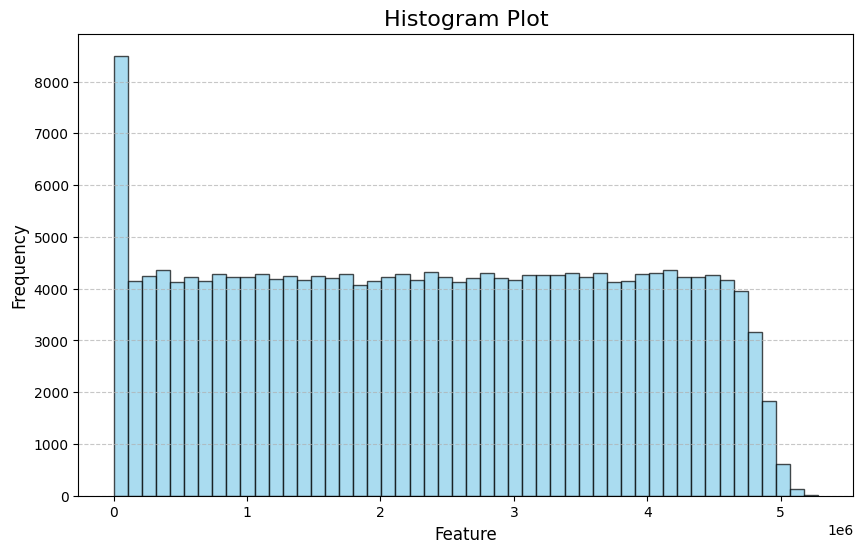

In [8]:
histogram_plot(df1, 'funds_after_6months')

* The even distribution is not representative of real-life data.

## 2. Data creation v2 (long tail distribution)

### 2.1 Key features

In [9]:
# number of rows and columns
num_clients = 200000

# Generate data for each column
np.random.seed(42)  # For reproducibility
data2 = {
    #"funds_now": np.round(np.random.uniform(0, 10000000, num_clients), 1),  # funds balance at the current month

    # demographics
    "age": np.random.randint(18, 91, num_clients),  # Age range: 18-90
    "tenure": np.random.randint(0, 61, num_clients),  # Tenure range: 0-60 years
    "credit_score": np.random.randint(400, 801, num_clients),  # Credit score: 400-800
    "annual_income": np.random.randint(20000, 300001, num_clients),  # Income: $20k-$300k
    
    # other debt balance 
    "mtg_balance": np.round( np.random.uniform(0, 1000001, num_clients), 1),  # Mortgage balance
    "credit_card_balance": np.round( np.random.uniform(0, 50001, num_clients), 1),  # Credit card balance
    "loan_balance": np.round( np.random.uniform(0, 300001, num_clients), 1),  # Other loan balance
    "splc_balance": np.round( np.random.uniform(0, 800001, num_clients), 1), # Secured personal line of credit balance

    # behaviors
    "inflow": np.round( np.random.uniform(10, 200001, num_clients), 1),  # Monthly inflow (income or deposits)
    "outflow": np.round( np.random.uniform(10, 150001, num_clients), 1),  # Monthly outflow (expenses)

    "mobile_banking_ind": np.random.choice([0, 1], num_clients),  # Mobile banking indicator
    "premium_ind": np.random.choice([0, 1], num_clients),  # Premium user indicator
    "newcomer_ind": np.random.choice([0, 1], num_clients),  # Newcomer indicator (1 if a new customer)
    "days_since_last_log": np.random.randint(0, 366, num_clients),  # Days since last login (1-365 days)

}

### 2.2 Create the current funds balance 

In [10]:
# Adjusting 'funds_now' and 'funds_after_6months' to follow a long-tail distribution
np.random.seed(42)  # For reproducibility

# Parameters for log-normal distribution
mu_now = 10  # Mean for funds_now
sigma_now = 0.7  # Standard deviation for funds_now

# Generating long-tail distributions
data2["funds_now"] = np.round(np.random.lognormal(mean=mu_now, sigma=sigma_now, size=num_clients), 1)

# Scale the values to match realistic fund ranges (e.g., $0 to $10M)
max_funds = 10000000
data2["funds_now"] = np.round((data2["funds_now"] / data2["funds_now"].max()) * max_funds, 1)

# Convert to DataFrame
df2 = pd.DataFrame(data2)


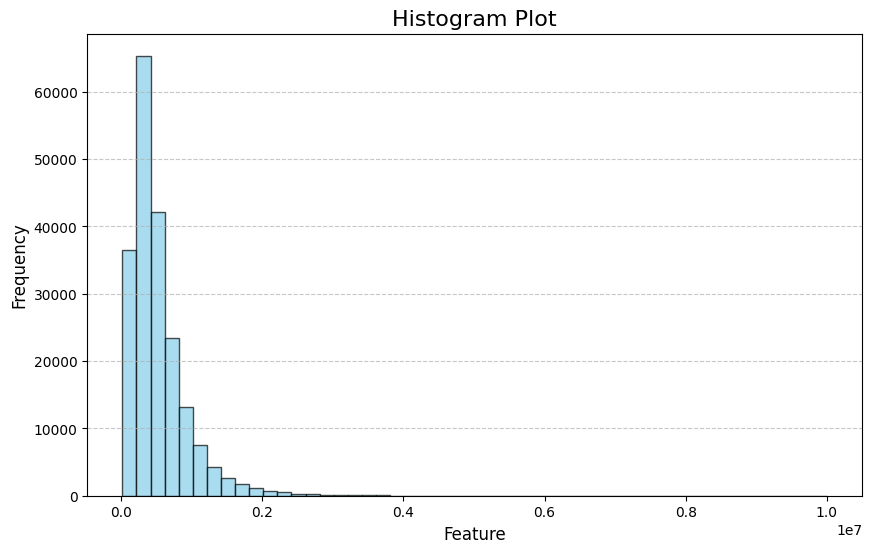

In [11]:
histogram_plot(df2,'funds_now')

* This makes more sense.

### 2.3 Create target (funds after 6 months)

In [12]:
# create target
df2["funds_after_6months"] = (
      0.5 * data2["funds_now"] 
    + 0.05 * data2["age"]
    + 0.08 * data2["tenure"]
    + 0.03 * data2["credit_score"]  # Credit score could impact balance growth
    + 0.2 * data2["annual_income"]  # Higher income may correlate with higher balances
    
    + 0.1 * data2["inflow"]  # Balance may increase with higher inflows
    - 0.06 * data2["outflow"]  # Decrease with higher outflows
    
    - 0.2 * data2["mtg_balance"]  # Higher mortgage balance may decrease balance growth
    - 0.1 * data2["credit_card_balance"]  # Higher credit card balance might reduce growth
    - 0.05 * data2["splc_balance"]  # secured plc might derease future balance
    - 0.15 * data2["loan_balance"]
    
    - 0.1 * data2["days_since_last_log"]  # Longer inactivity might slightly decrease balance
    + 0.2 * data2["mobile_banking_ind"]
    + 0.3 * data2["premium_ind"]
    - 0.2 * data2["newcomer_ind"]
    
    + np.random.normal(0, 100000, num_clients)  # Adding some noise
)

# Clip the balance after 6 months to a reasonable range (0 to 11 million)
df2["funds_after_6months"] = np.round(np.clip(df2["funds_after_6months"], 0, 11000000), 1)


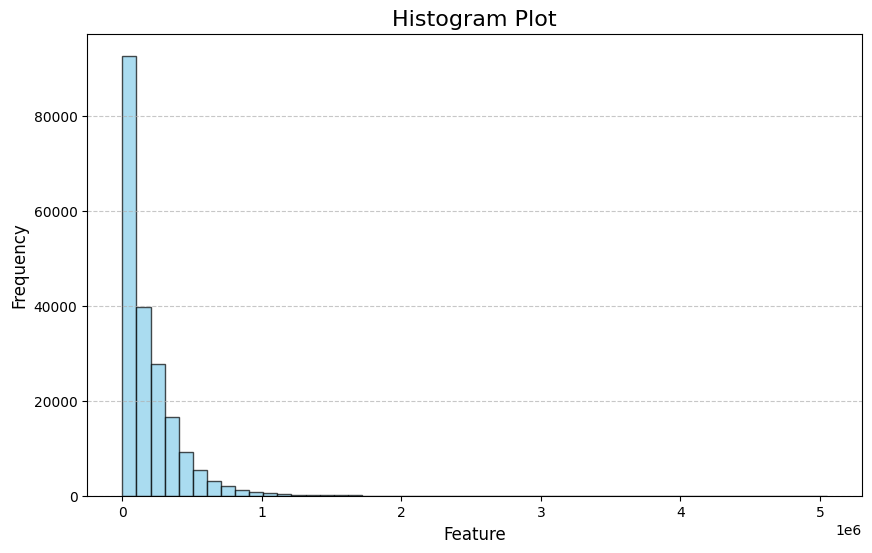

In [13]:
histogram_plot(df2, 'funds_after_6months')

* Closer to real-life data.

In [14]:
# Generate feature 16 to 30 (positive float)
for i in range(16, 31):
    df2[f"fea{i}"] = np.round( np.random.rand(num_clients) * 200000, 1)  # Scale to desired range

# Generate feature 31 to 46 (positive or negative float)
for i in range(31, 46):
    df2[f"fea{i}"] = np.round( (np.random.rand(num_clients) - 0.5) * 100000, 1)  # Centered around 0, scale to desired range

# Generate last 5 features (binary: 0 or 1)
for i in range(46, 51):
    df2[f"fea{i}"] = np.round( np.random.randint(0, 2, num_clients) , 1 )


In [15]:
df2.head()

,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,splc_balance,inflow,outflow,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
0,69,44,443,158191,211023.6,13320.2,11516.5,479247.7,47613.0,37088.8,...,10232.7,26721.0,39983.1,45532.4,11885.7,1,1,1,0,1
1,32,43,496,208050,19841.3,45983.3,119858.9,792069.0,84275.9,45818.6,...,-26726.7,-19164.4,22911.3,-9997.3,3621.1,1,0,0,0,0
2,89,55,527,148731,854416.8,41016.9,31300.6,303507.5,8288.9,55787.4,...,-15244.7,4683.6,32100.5,-32710.4,39201.2,1,1,1,1,0
3,78,1,628,263843,850936.3,2612.9,73886.1,147897.5,447.3,71366.5,...,18567.4,28572.1,-44307.5,-43039.7,156.0,1,1,1,1,0
4,38,16,764,264430,979270.8,5583.3,252329.3,89308.4,80137.0,73929.6,...,-15909.1,-33315.5,-32351.8,15200.4,-7349.3,0,0,1,1,0


## 3. Test it with a lgb model

In [16]:
X = df2.drop(columns=['funds_after_6months'])
y = df2['funds_after_6months']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
baseline_params = {
    'max_depth': 3,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.5
}

In [19]:
lgb_dev1 = lightgbm_dev_v2(X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test,
                   baseline_params = baseline_params,
                   baseline_ind=1,
                   max_evals=2,
                   search_space={})

In [20]:
lgb1 = lgb_dev1.run_model()

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10335
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 50
[LightGBM] [Info] Start training from score 177372.881641
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


2024/12/29 14:28:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: 2b090c490d914f45a4adef1a2fb4e11b


In [21]:
lgb1_id = lgb1[1]

In [22]:
# Fetch the run details using MLflow API
run = mlflow.get_run(lgb1_id)

# Retrieve the metrics from the run
rmse_train = run.data.metrics.get("rmse_train", None)
rmse_test = run.data.metrics.get("rmse_test", None)
r2_train = run.data.metrics.get("r2_train", None)
r2_test = run.data.metrics.get("r2_test", None)
pr_train = run.data.metrics.get("powerratio_train", None)
pr_test = run.data.metrics.get("powerratio_test", None)

# Print the retrieved metrics
print(f"RMSE Train: {rmse_train}")
print(f"RMSE Test: {rmse_test}")
print(f"R2 Train: {r2_train}")
print(f"R2 Test: {r2_test}")
print(f"Power Ratio Train: {pr_train}")
print(f"Power Ratio Test: {pr_test}")

RMSE Train: 87770.7400240617
RMSE Test: 86609.55448186008
R2 Train: 0.8333200522248513
R2 Test: 0.8369694504048327
Power Ratio Train: 0.9399571243192203
Power Ratio Test: 0.9392194799982692


* The metrics make sense.

## 4. Final prep (add id, re-order)

In [23]:
# add id
df2['id'] = pd.Series(range(1,200001))

In [24]:
df2.head()

,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,splc_balance,inflow,outflow,...,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50,id
0,69,44,443,158191,211023.6,13320.2,11516.5,479247.7,47613.0,37088.8,...,26721.0,39983.1,45532.4,11885.7,1,1,1,0,1,1
1,32,43,496,208050,19841.3,45983.3,119858.9,792069.0,84275.9,45818.6,...,-19164.4,22911.3,-9997.3,3621.1,1,0,0,0,0,2
2,89,55,527,148731,854416.8,41016.9,31300.6,303507.5,8288.9,55787.4,...,4683.6,32100.5,-32710.4,39201.2,1,1,1,1,0,3
3,78,1,628,263843,850936.3,2612.9,73886.1,147897.5,447.3,71366.5,...,28572.1,-44307.5,-43039.7,156.0,1,1,1,1,0,4
4,38,16,764,264430,979270.8,5583.3,252329.3,89308.4,80137.0,73929.6,...,-33315.5,-32351.8,15200.4,-7349.3,0,0,1,1,0,5


In [25]:
# reorder 
order1 = ['id', 'funds_now', 'funds_after_6months', 
                 "age", "tenure", "credit_score", "annual_income",
                 "mtg_balance", "credit_card_balance", "loan_balance", 
                 "splc_balance", "inflow", "outflow",
                 "mobile_banking_ind", "premium_ind", "newcomer_ind","days_since_last_log"] + [f'fea{i}' for i in range(16, 51)]


In [26]:
df3 = df2[order1]
df3.head()

,id,funds_now,funds_after_6months,age,tenure,credit_score,annual_income,mtg_balance,credit_card_balance,loan_balance,...,fea41,fea42,fea43,fea44,fea45,fea46,fea47,fea48,fea49,fea50
0,1,580888.6,411571.0,69,44,443,158191,211023.6,13320.2,11516.5,...,10232.7,26721.0,39983.1,45532.4,11885.7,1,1,1,0,1
1,2,372438.7,157944.4,32,43,496,208050,19841.3,45983.3,119858.9,...,-26726.7,-19164.4,22911.3,-9997.3,3621.1,1,0,0,0,0
2,3,645639.9,22235.5,89,55,527,148731,854416.8,41016.9,31300.6,...,-15244.7,4683.6,32100.5,-32710.4,39201.2,1,1,1,1,0
3,4,1191515.2,316512.4,78,1,628,263843,850936.3,2612.9,73886.1,...,18567.4,28572.1,-44307.5,-43039.7,156.0,1,1,1,1,0
4,5,348260.8,0.0,38,16,764,264430,979270.8,5583.3,252329.3,...,-15909.1,-33315.5,-32351.8,15200.4,-7349.3,0,0,1,1,0


In [27]:
df3.shape

(200000, 52)

In [28]:
# save
df3.to_csv('df.csv', index=False)